In [10]:
import numpy as np  #load up the libraries and object defs. we need
import pandas as pd
from pandas import DataFrame, Series

# load up my visualization system, and call the object plt
import matplotlib.pyplot as plt

# tell ipython notebook to print visualizations inline
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


For the Encyclopedia Sales dataset, 

In [11]:
df = pd.read_csv('sales.csv')
df = df.set_index('day')
df.head(10)

,Seller 1,Seller 2,Seller 3,Seller 4,Seller 5,Seller 6
day,,,,,,
1,320,80,139,330,133,387
2,74,60,98,44,182,29
3,340,67,42,100,51,91
4,322,54,89,44,67,886
5,146,195,47,173,49,227
6,24,288,124,111,730,79
7,42,249,26,77,672,45
8,76,67,140,382,195,171
9,99,312,125,123,43,98


# Manually computing confidence intervals

We can compute exact confidence intervals using the mean and standard deviation

`ci = mean ± (t*std)`

Where `t` depends on what confidence interval we want.

In [14]:
t=1.96 #For 95% CIs

In [15]:
df.mean()

Seller 1    148.766667
Seller 2    154.233333
Seller 3    121.500000
Seller 4    143.233333
Seller 5    173.233333
Seller 6    194.866667
dtype: float64

In [16]:
df.std()

Seller 1    170.761314
Seller 2    186.324093
Seller 3     81.269136
Seller 4    123.869142
Seller 5    196.273856
Seller 6    262.876362
dtype: float64

In [17]:
sqn=sqrt(len(df))
sqn

5.4772255750516612

In [18]:
cis = DataFrame({'mean':df.mean(), 'ci':t*df.std()/sqn})
cis

,ci,mean
Seller 1,61.106152,148.766667
Seller 2,66.675221,154.233333
Seller 3,29.081787,121.500000
Seller 4,44.326003,143.233333
Seller 5,70.235697,173.233333
Seller 6,94.069098,194.866667


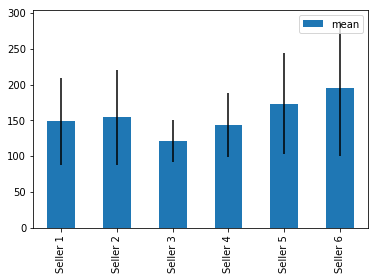

In [19]:
cis.plot(kind="bar", yerr="ci")

# Let's check if our data is normally distributed

First we pivot the dataframe using the `melt` command to put all of the values into one 'Sales' column. 

In [20]:
df_pivot = pd.melt(df,value_vars=['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6'], 
                   var_name="Sellers", value_name="Sales")
df_pivot.tail(5)

,Sellers,Sales
175,Seller 6,173
176,Seller 6,24
177,Seller 6,82
178,Seller 6,58
179,Seller 6,27


Then we can use a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) (a quantile-quantile plot) to see if we have a normal distribution.

To do that we plot the sales values against a randomly generated normally-distributed set of new values.

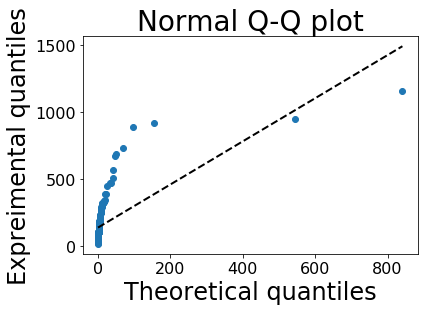

In [21]:
# http://scientificpythonsnippets.com/index.php/distributions/6-q-q-plot-in-python-to-test-if-data-is-normally-distributed

# get all of the sales values and plot them against a normally-distributed set of quantiles
sales = df_pivot["Sales"].copy()
sales.sort_values(inplace=True)
norm=random.lognormal(0,2,len(sales))
norm.sort()
plt.plot(norm,sales,"o")

# add a trend line and make it pretty
z = np.polyfit(norm,sales, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=28)
plt.xlabel("Theoretical quantiles", size=24)
plt.ylabel("Expreimental quantiles", size=24)
plt.tick_params(labelsize=16)


For comparison, we can also plot two normally distributed sets against one another.

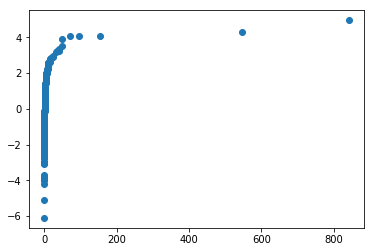

In [22]:
norm2=random.normal(0,2,len(sales))
norm2.sort()
plt.plot(norm,norm2,"o")

If the data isn't normally distributed. Bootstrap CIs might be a better choice.

(A histogram could also have shown us this.)

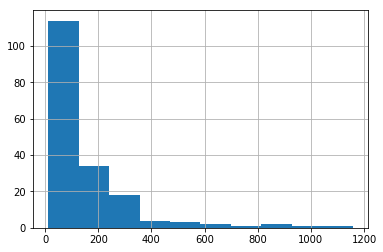

In [23]:
sales.hist()

This data probably has a log-normal distribution. Which we can test by taking the log.

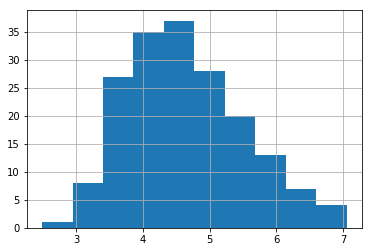

In [24]:
np.log(sales).hist()

...we can always reverse that by taking the exponent.

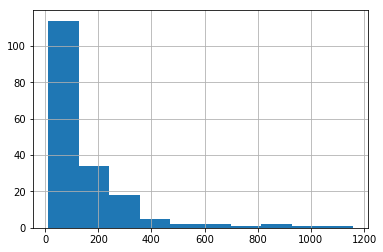

In [25]:
np.exp(np.log(sales)).hist()

If we wanted to, we could log-transform the data, compute CIs, then convert back before plotting.
This would give more accurate confidence intervals (you can try later if you'd like).
Instead, for now, we'll compute bootstrap confidence intervals.

# Bootstrap confidence intervals in Seaborn

The [Seaborn charting package](https://seaborn.github.io) supports bootstrap confidence intervals by default on most of it's chart types. 

If you don't already have seaborn installed, open a terminal or command prompt and run:
`conda install seaborn`

In [26]:
# Import seaborn
import seaborn as sns

**Draw a bar plot to show each seller.**

Use the `ci` parameter to set the confidence interval and the `n_boot` parameter to set the number of samples.

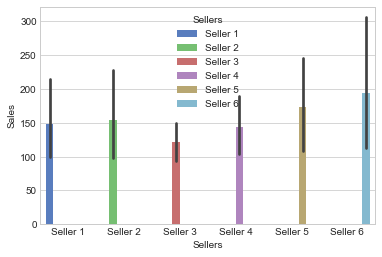

In [27]:
sns.set_style('whitegrid')
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=1000)

**Try experimenting with different sized confidence intervals and different numbers of bootstrap samples.**

*How does this change the size of the confidence intervals?*
*What happens if you re-run multiple times?*

# Confidence intervals for pairwise comparisons
If we want to see if one seller reliably sells more than another seller on a daily basis, we can test that directly.

In [28]:
df_comp = DataFrame({"Seller 6 - 3":(df['Seller 6'] - df['Seller 3']),
                     "Seller 6 - 5":(df['Seller 6'] - df['Seller 5'])})
df_comp.head(5)

,Seller 6 - 3,Seller 6 - 5
day,,
1,248,254
2,-69,-153
3,49,40
4,797,819
5,180,178


In [29]:
df_comp_pivot = pd.melt(df_comp,value_vars=['Seller 6 - 3','Seller 6 - 5'], 
                   var_name="Seller Pair", value_name="Difference in Sales")
df_comp_pivot.tail(5)

,Seller Pair,Difference in Sales
55,Seller 6 - 5,104
56,Seller 6 - 5,-24
57,Seller 6 - 5,-13
58,Seller 6 - 5,-182
59,Seller 6 - 5,-18


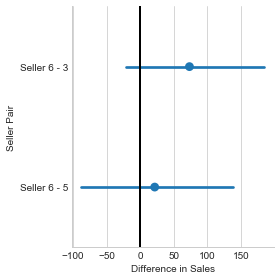

In [30]:
sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

# Now...
Have a look at the `sales-full.csv` dataset.
Are there any clear differences in it?

In [39]:
df = pd.read_csv('sales-full.csv')
df

,day,Seller 1,Seller 2,Seller 3,Seller 4,Seller 5,Seller 6
0,1,320,89,21,57,57,107
1,2,74,386,181,71,29,95
2,3,340,186,151,108,342,78
3,4,322,606,257,96,167,423
4,5,146,78,269,527,321,70
5,6,24,31,152,73,14,497
6,7,42,69,178,50,435,36
7,8,76,109,58,22,211,222
8,9,99,80,430,39,95,163
9,10,915,68,19,1092,257,27


**Question #1**
Based on the full data, are any of the encyclopedia sellers in this set clearly different from the others in terms of average daily sales? Who would you give a raise?

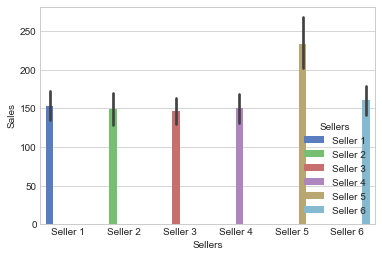

In [32]:
cis = DataFrame({'mean':df.mean(), 'ci':t*df.std()/sqn})
df_pivot = pd.melt(df,value_vars=['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6'], 
                   var_name="Sellers", value_name="Sales")
df_pivot.tail(5)
# Import seaborn
import seaborn as sns

sns.set_style('whitegrid')
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95)

**Question #2**
We have data from six sellers from a company with many more. Based on this sample, does it look like the weeks with the best *average daily sales per seller* are clearly different from the weeks with the worst *average daily sales per seller*? 
*(Be sure to think about your unit of analysis.)*

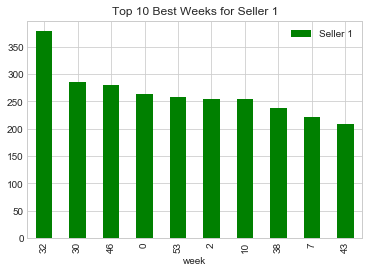

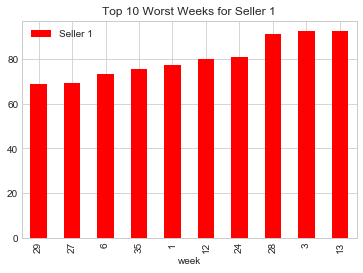

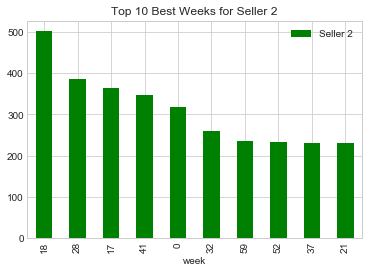

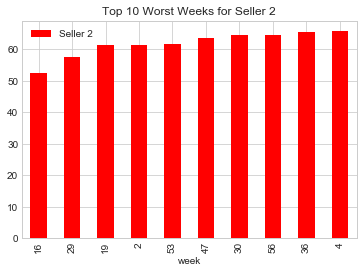

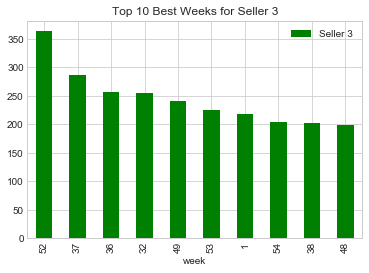

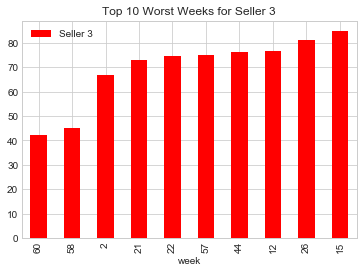

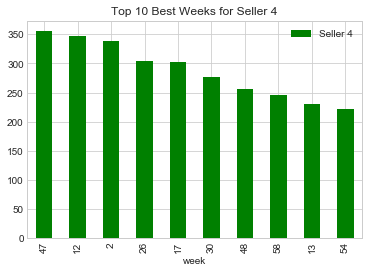

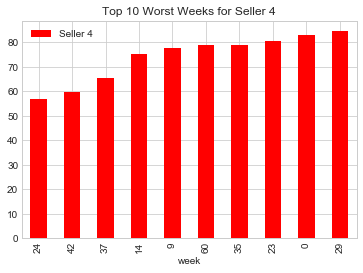

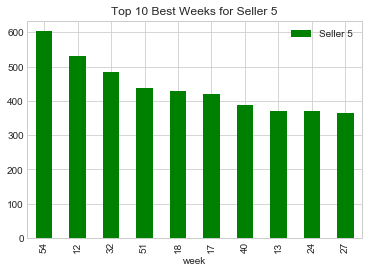

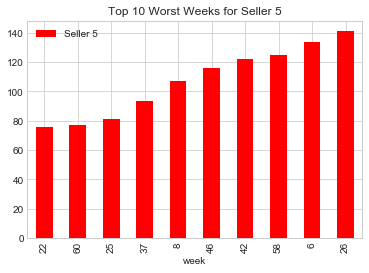

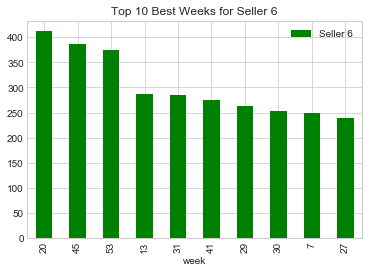

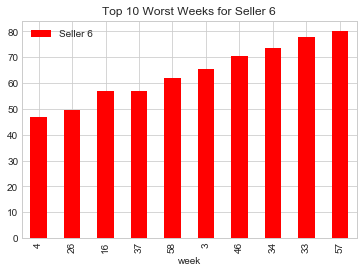

In [33]:
df_copy = df.copy()

#we make another column called week, this is achieved by doing an integer division over 5 days.
df_copy['week'] = (df_copy['day']//5)

#the day column is irrelevant now.
del df_copy['day'] 

#we take the average of each week per seller
df_g = df_copy.groupby('week').mean()

for x in range(1,7):  
   
    #generate plot for best 10 weeks per seller
    best=df_g[["Seller "+str(x)]].sort_values(by="Seller "+str(x), ascending=False).head(10)
    bestPlot = best.plot(kind='bar', color = 'green', title=('Top 10 Best Weeks for Seller '+str(x)))

    #generate plot for worst 10 weeks per seller
    worst=df_g[["Seller "+str(x)]].sort_values(by="Seller "+str(x)).head(10)
    worstPlot = worst.plot(kind='bar', color = 'red',title=('Top 10 Worst Weeks for Seller '+str(x)))



    

**Question #3** {Question of your choice.}

In [34]:
What day of the week generates the most sales?

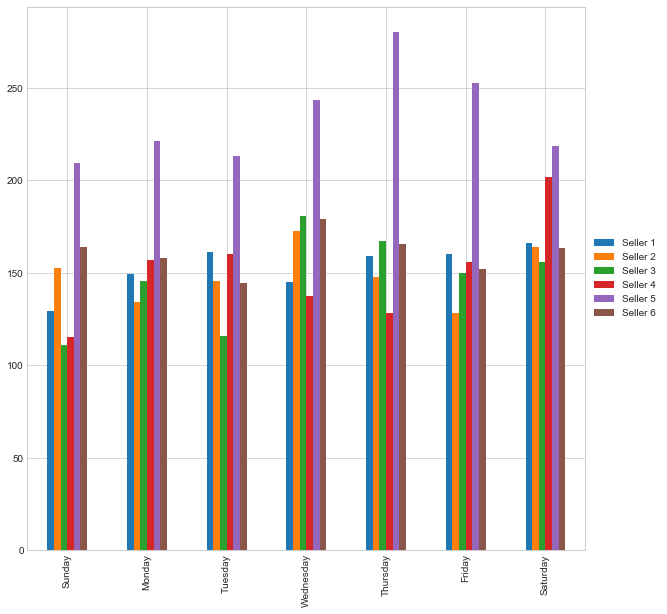

In [42]:
# make a copy of dataframe
df_days = df.copy()

# add days of the week as a column
df_days['Day of week'] = (df_days.index % 7)

# get the mean of each day
df_days = df_days.groupby('Day of week').mean()
df_days = df_days.drop('day',axis=1)

# change the numbers to readable days
index_list = df_days.index.tolist()
index_list[0] = 'Sunday'
index_list[1] = 'Monday'
index_list[2] = 'Tuesday'
index_list[3] = 'Wednesday'
index_list[4] = 'Thursday'
index_list[5] = 'Friday'
index_list[6] = 'Saturday'
df_days.index = index_list

# plot a graph
plotVariable = df_days.plot(kind='bar',figsize=(10,10))
plotVariable.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

plt.savefig('3_Days of week.png')